In [1]:
# Imports
import os
import requests
import pandas as pd
#import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import panel as pn
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv
import yfinance as yf

%matplotlib inline

C:\Users\jorda\anaconda3\envs\pyvizenv\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)



Bad key "text.kerning_factor" on line 4 in
C:\Users\jorda\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
# Stock Shares
my_qqq = 100
my_CM = 1000
my_msft = 100
my_2357 = 100
my_tsla = 100
my_pfe = 1000
my_nvda = 100
my_f = 1000
my_ccl = 1000
my_ac = 1000

# Share Purchase Price
price_qqq = 349.46
price_CM = 23.76
price_msft = 265.02
price_2357 = 367
price_tsla = 671.87
price_pfe = 38.98
price_nvda = 761.24
price_f = 15.19
price_ccl = 28.13
price_ac = 25.91

# Stock Cost Basis
cost_qqq = my_qqq * price_qqq
cost_CM = my_CM * price_CM
cost_msft = my_msft * price_msft
cost_2357 = my_2357 * price_2357
cost_tsla = my_tsla * price_tsla
cost_pfe = my_pfe * price_pfe
cost_nvda = my_nvda * price_nvda
cost_f = my_f * price_f
cost_ccl = my_ccl * price_ccl
cost_ac = my_ac * price_ac

stock_cost = cost_qqq + cost_CM + cost_msft + cost_2357 + cost_tsla + cost_pfe + cost_nvda + cost_f + cost_ccl + cost_ac

# List needs to be alphabetical to allow weights to read in-lin with stock data
stock_weight = [cost_2357/stock_cost,
                    cost_ac/stock_cost, 
                    cost_ccl/stock_cost, 
                    cost_CM/stock_cost, 
                    cost_f/stock_cost, 
                    cost_msft/stock_cost, 
                    cost_nvda/stock_cost, 
                    cost_pfe/stock_cost, 
                    cost_qqq/stock_cost, 
                    cost_tsla/stock_cost]

stock_weight

[0.09827838759175105,
 0.06938400606273214,
 0.07532891125220591,
 0.06362655283869223,
 0.04067707649914709,
 0.07096931411325848,
 0.20385133452409962,
 0.10438396589445383,
 0.09358137691502266,
 0.179919074308637]

In [4]:
# Stock Data
stockStrings = ['QQQ', 'CM-PQ.TO', 'MSFT', '2357.TW', 'TSLA', 'PFE', 'NVDA', 'F', 'CCL', 'AC.TO']

stock_close = yf.download(stockStrings, group_by='Ticker', period='10y')

# Create CSV of ticker data
stock_close.to_csv('stocks.csv')

stock_close = stock_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

stock_close = pd.read_csv('stocks.csv', header=[0, 1])
stock_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
stock_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(stock_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
stock_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
stock_close.index.name = None

# Drop Null Information
stock_close = stock_close.dropna()

# Sort Multi-Index To Match Weights
stock_close = stock_close.reindex(sorted(stock_close.columns), axis=1)

stock_close

[*********************100%***********************]  10 of 10 completed


2357.TW                                             AC.TO  \
             Adj Close  Close   High    Low   Open     Volume  Adj Close   
2015-03-11  223.824799  322.0  326.5  322.0  323.0  2017000.0  12.410000   
2015-03-12  225.215042  324.0  325.5  321.5  322.0  1818000.0  12.390000   
2015-03-13  224.172363  322.5  325.0  322.0  323.0  2127000.0  12.210000   
2015-03-16  221.044373  318.0  323.0  316.0  320.0  4840000.0  12.400000   
2015-03-17  220.696838  317.5  322.5  315.0  320.5  3586000.0  12.500000   
...                ...    ...    ...    ...    ...        ...        ...   
2021-06-21  383.000000  383.0  387.5  383.0  385.0  3666987.0  27.400000   
2021-06-22  375.000000  375.0  388.0  375.0  383.0  6994544.0  27.299999   
2021-06-23  374.000000  374.0  376.5  370.5  375.0  5798938.0  26.770000   
2021-06-24  373.500000  373.5  377.0  372.0  375.0  2744945.0  26.379999   
2021-06-25  367.000000  367.0  375.0  367.0  375.0  6370441.0  25.910000   

                                             ...         QQQ              \
                Close       High        Low  ...        High         Low   
2015-03-11  12.410000  12.520000  12.200000  ...  106.010002  105.070000   
2015-03-12  12.390000  12.540000  12.360000  ...  105.919998  104.959999   
2015-03-13  12.210000  12.430000  12.030000  ...  106.120003  104.680000   
2015-03-16  12.400000  12.440000  12.200000  ...  106.739998  105.620003   
2015-03-17  12.500000  12.540000  12.340000  ...  107.040001  106.160004   
...               ...        ...        ...  ...         ...         ...   
2021-06-21  27.400000  27.990000  27.219999  ...  344.690002  340.149994   
2021-06-22  27.299999  27.530001  27.120001  ...  348.029999  343.839996   
2021-06-23  26.770000  27.510000  26.770000  ...  348.920013  346.880005   
2021-06-24  26.379999  27.070000  26.320000  ...  351.459991  349.170013   
2021-06-25  25.910000  26.459999  25.900000  ...  350.720001  348.839996   

                                          TSLA                          \
                  Open      Volume   Adj Close       Close        High   
2015-03-11  105.879997  25459700.0   38.748001   38.748001   39.236000   
2015-03-12  105.029999  21473200.0   38.214001   38.214001   38.889999   
2015-03-13  105.699997  42021100.0   37.736000   37.736000   38.349998   
2015-03-16  105.730003  25674100.0   39.139999   39.139999   39.181999   
2015-03-17  106.410004  19603800.0   38.945999   38.945999   39.742001   
...                ...         ...         ...         ...         ...   
2021-06-21  342.429993  32992600.0  620.830017  620.830017  631.390015   
2021-06-22  344.149994  28941600.0  623.710022  623.710022  628.570007   
2021-06-23  347.510010  27188500.0  656.570007  656.570007  657.200012   
2021-06-24  349.730011  32581600.0  679.820007  679.820007  697.619995   
2021-06-25  350.470001  28627400.0  671.869995  671.869995  693.809998   

                                                
                   Low        Open      Volume  
2015-03-11   38.202000   38.230000  24874500.0  
2015-03-12   37.950001   38.750000  20746500.0  
2015-03-13   37.464001   37.790001  27171500.0  
2015-03-16   37.959999   38.400002  28144000.0  
2015-03-17   38.787998   39.085999  24470500.0  
...                ...         ...         ...  
2021-06-21  608.880005  624.479980  24812700.0  
2021-06-22  615.500000  618.250000  19158900.0  
2021-06-23  630.039978  632.000000  31099200.0  
2021-06-24  667.609985  674.989990  45982400.0  
2021-06-25  668.700012  689.580017  32429000.0  

[1461 rows x 60 columns]

In [5]:
# Configuring a Monte Carlo simulation to forecast 1 year cumulative returns
MC_stock_one_year = MCSimulation(
    portfolio_data = stock_close,
    weights = stock_weight,
    num_simulation = 500,
    num_trading_days = 252 * 1
)

In [6]:
# Printing the simulation input data
MC_stock_one_year.portfolio_data.head()

2357.TW                                                      \
             Adj Close  Close   High    Low   Open     Volume daily_return   
2015-03-11  223.824799  322.0  326.5  322.0  323.0  2017000.0          NaN   
2015-03-12  225.215042  324.0  325.5  321.5  322.0  1818000.0     0.006211   
2015-03-13  224.172363  322.5  325.0  322.0  323.0  2127000.0    -0.004630   
2015-03-16  221.044373  318.0  323.0  316.0  320.0  4840000.0    -0.013953   
2015-03-17  220.696838  317.5  322.5  315.0  320.5  3586000.0    -0.001572   

               AC.TO                ...         QQQ                           \
           Adj Close  Close   High  ...        Open      Volume daily_return   
2015-03-11     12.41  12.41  12.52  ...  105.879997  25459700.0          NaN   
2015-03-12     12.39  12.39  12.54  ...  105.029999  21473200.0     0.006565   
2015-03-13     12.21  12.21  12.43  ...  105.699997  42021100.0    -0.004348   
2015-03-16     12.40  12.40  12.44  ...  105.730003  25674100.0     0.012911   
2015-03-17     12.50  12.50  12.54  ...  106.410004  19603800.0     0.001593   

                 TSLA                                                          \
            Adj Close      Close       High        Low       Open      Volume   
2015-03-11  38.748001  38.748001  39.236000  38.202000  38.230000  24874500.0   
2015-03-12  38.214001  38.214001  38.889999  37.950001  38.750000  20746500.0   
2015-03-13  37.736000  37.736000  38.349998  37.464001  37.790001  27171500.0   
2015-03-16  39.139999  39.139999  39.181999  37.959999  38.400002  28144000.0   
2015-03-17  38.945999  38.945999  39.742001  38.787998  39.085999  24470500.0   

                         
           daily_return  
2015-03-11          NaN  
2015-03-12    -0.013781  
2015-03-13    -0.012509  
2015-03-16     0.037206  
2015-03-17    -0.004957  

[5 rows x 70 columns]

In [7]:
# Running a Monte Carlo simulation to forecast 1 year cumulative returns
MC_stock_one_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.001555  0.997394  1.015288  0.988547  0.999776  0.983849  1.009187   
2    0.999304  1.005082  1.016542  0.994393  1.007501  0.997292  1.002301   
3    0.983764  0.998996  1.030134  0.994900  1.012786  1.009201  0.990863   
4    0.995142  0.995009  1.036999  0.981048  1.007903  1.007999  0.992426   
..        ...       ...       ...       ...       ...       ...       ...   
248  1.551938  1.696655  1.232735  1.639948  1.119809  1.152131  1.423121   
249  1.551834  1.696051  1.228967  1.619090  1.106494  1.147183  1.404500   
250  1.580363  1.682884  1.252298  1.614513  1.114696  1.142889  1.407244   
251  1.597379  1.706858  1.248962  1.622414  1.112435  1.139807  1.429858   
252  1.602616  1.703804  1.244431  1.632784  1.113678  1.163634  1.421826   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.009201  1.005988  0.997212  ...  1.002167  0.998397  0.990091   
2    0.984684  1.010272  0.998717  ...  1.002043  0.996749  1.001785   
3    0.992443  1.018045  0.996904  ...  1.017345  1.008903  0.990639   
4    0.994709  1.023931  0.989576  ...  1.000977  0.998573  0.988554   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.316332  1.319691  1.119311  ...  1.552684  1.165254  1.619031   
249  1.327640  1.322591  1.132392  ...  1.545751  1.149207  1.600677   
250  1.324925  1.319962  1.143948  ...  1.556092  1.162112  1.604885   
251  1.327734  1.346456  1.154662  ...  1.560156  1.152464  1.639426   
252  1.327135  1.343808  1.151372  ...  1.568195  1.149985  1.653489   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.994240  0.992931  0.989971  0.997904  0.994487  0.995577  0.994478  
2    0.985023  1.001183  0.981910  0.993855  1.006508  0.991876  0.994800  
3    0.968917  0.999004  0.975350  0.997264  1.007048  0.995209  0.989490  
4    0.969983  0.999814  0.972211  0.987793  1.001314  0.988694  0.993766  
..        ...       ...       ...       ...       ...       ...       ...  
248  1.724595  1.322889  1.668307  1.132153  1.177552  1.315686  2.010698  
249  1.747854  1.321126  1.700190  1.124570  1.178585  1.316618  2.005867  
250  1.756157  1.313394  1.710966  1.143262  1.196739  1.343654  2.017900  
251  1.760680  1.327138  1.704643  1.138949  1.207381  1.333001  2.008732  
252  1.778792  1.332047  1.699103  1.142557  1.214655  1.342687  1.972038  

[253 rows x 500 columns]

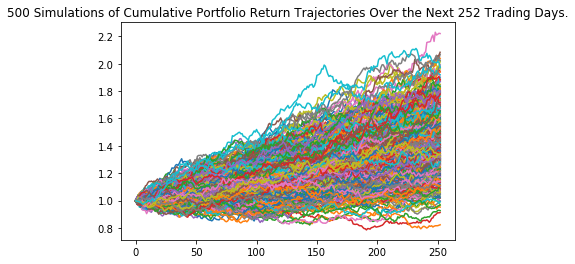

In [8]:
# Plot simulation outcomes
stock_oneyr_line_plot = MC_stock_one_year.plot_simulation()

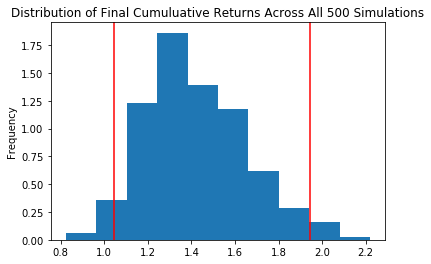

In [9]:
# Plot probability distribution and confidence intervals
stock_oneyr_dist_plot = MC_stock_one_year.plot_distribution()

In [10]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_oneyr_tbl = MC_stock_one_year.summarize_cumulative_return()

# Print summary statistics
print(stock_oneyr_tbl)

count           500.000000
mean              1.422399
std               0.232082
min               0.823309
25%               1.260310
50%               1.388300
75%               1.568894
max               2.220407
95% CI Lower      1.044039
95% CI Upper      1.942916
Name: 252, dtype: float64


In [11]:
# Configuring a Monte Carlo simulation to forecast 5 year cumulative returns
MC_stock_five_year = MCSimulation(
    portfolio_data = stock_close,
    weights = stock_weight,
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [12]:
# Printing the simulation input data
MC_stock_five_year.portfolio_data.head()

2357.TW                                                      \
             Adj Close  Close   High    Low   Open     Volume daily_return   
2015-03-11  223.824799  322.0  326.5  322.0  323.0  2017000.0          NaN   
2015-03-12  225.215042  324.0  325.5  321.5  322.0  1818000.0     0.006211   
2015-03-13  224.172363  322.5  325.0  322.0  323.0  2127000.0    -0.004630   
2015-03-16  221.044373  318.0  323.0  316.0  320.0  4840000.0    -0.013953   
2015-03-17  220.696838  317.5  322.5  315.0  320.5  3586000.0    -0.001572   

               AC.TO                ...         QQQ                           \
           Adj Close  Close   High  ...        Open      Volume daily_return   
2015-03-11     12.41  12.41  12.52  ...  105.879997  25459700.0          NaN   
2015-03-12     12.39  12.39  12.54  ...  105.029999  21473200.0     0.006565   
2015-03-13     12.21  12.21  12.43  ...  105.699997  42021100.0    -0.004348   
2015-03-16     12.40  12.40  12.44  ...  105.730003  25674100.0     0.012911   
2015-03-17     12.50  12.50  12.54  ...  106.410004  19603800.0     0.001593   

                 TSLA                                                          \
            Adj Close      Close       High        Low       Open      Volume   
2015-03-11  38.748001  38.748001  39.236000  38.202000  38.230000  24874500.0   
2015-03-12  38.214001  38.214001  38.889999  37.950001  38.750000  20746500.0   
2015-03-13  37.736000  37.736000  38.349998  37.464001  37.790001  27171500.0   
2015-03-16  39.139999  39.139999  39.181999  37.959999  38.400002  28144000.0   
2015-03-17  38.945999  38.945999  39.742001  38.787998  39.085999  24470500.0   

                         
           daily_return  
2015-03-11          NaN  
2015-03-12    -0.013781  
2015-03-13    -0.012509  
2015-03-16     0.037206  
2015-03-17    -0.004957  

[5 rows x 70 columns]

In [13]:
# Running a Monte Carlo simulation to forecast 5 year cumulative returns
MC_stock_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4          5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000   1.000000  1.000000   
1     0.987706  0.995673  1.005385  1.004181  1.014377   0.997420  0.988441   
2     0.991285  1.000496  1.008270  1.010958  1.023894   1.005039  0.998533   
3     0.984744  1.012279  1.009043  1.011190  1.019591   1.008720  1.031032   
4     0.985865  1.017301  1.006457  1.006887  1.022312   1.017531  1.041281   
...        ...       ...       ...       ...       ...        ...       ...   
1256  4.259792  3.847768  2.989007  4.868731  2.079627  11.148889  7.954578   
1257  4.180457  3.839853  3.005394  4.889683  2.055585  11.278849  7.944907   
1258  4.144404  3.858407  3.009882  4.870845  2.056340  11.259070  7.916492   
1259  4.106830  3.855039  2.989212  4.830913  2.039252  11.325824  7.832197   
1260  4.198533  3.894123  2.978652  4.825485  2.031563  11.408216  7.789029   

           7          8         9    ...       490       491       492  \
0     1.000000   1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.988333   1.011512  1.009834  ...  1.011861  1.000253  0.980193   
2     0.984163   1.021639  1.013669  ...  0.999825  1.001082  0.989882   
3     0.972780   1.031853  1.003553  ...  0.995160  1.004695  0.989003   
4     0.981029   1.048539  0.994886  ...  0.988361  1.004637  0.980736   
...        ...        ...       ...  ...       ...       ...       ...   
1256  5.357165  11.552485  5.311229  ...  3.641687  3.629422  4.766168   
1257  5.430083  11.565706  5.326526  ...  3.635473  3.689581  4.768957   
1258  5.542115  11.367232  5.367757  ...  3.693064  3.699797  4.746751   
1259  5.497644  11.615400  5.450897  ...  3.782704  3.763866  4.811647   
1260  5.521780  11.807541  5.482514  ...  3.786157  3.715787  4.825710   

           493       494       495       496       497       498        499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   1.000000  
1     1.007208  1.006870  0.997982  1.008315  1.003931  1.009861   1.005280  
2     1.019021  0.996766  0.986383  1.024107  1.006904  0.993459   0.990296  
3     1.030837  1.010835  0.999106  1.022680  1.010236  0.998863   0.986470  
4     1.025919  1.024501  1.003852  1.046246  1.017354  1.000376   0.963372  
...        ...       ...       ...       ...       ...       ...        ...  
1256  3.411918  6.487816  8.328946  4.275058  4.412611  3.363368  12.059315  
1257  3.379130  6.405224  8.236819  4.258454  4.494292  3.378461  12.119170  
1258  3.367101  6.348110  8.299290  4.253839  4.526675  3.346249  12.367217  
1259  3.380187  6.331554  8.196954  4.240584  4.505680  3.327118  12.472398  
1260  3.498672  6.377534  8.138062  4.232304  4.528172  3.303172  12.497534  

[1261 rows x 500 columns]

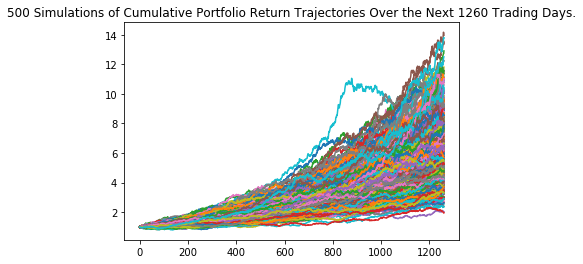

In [14]:
# Plot simulation outcomes
stock_fiveyr_line_plot = MC_stock_five_year.plot_simulation()

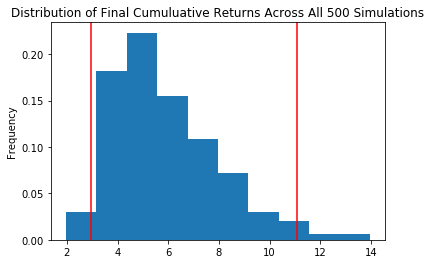

In [15]:
# Plot probability distribution and confidence intervals
Stock_fiveyr_dist_plot = MC_stock_five_year.plot_distribution()

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
stock_fiveyr_tbl = MC_stock_five_year.summarize_cumulative_return()

# Print summary statistics
print(stock_fiveyr_tbl)

count           500.000000
mean              5.913387
std               2.106940
min               1.955910
25%               4.350952
50%               5.480111
75%               7.115106
max              13.963032
95% CI Lower      2.941993
95% CI Upper     11.077808
Name: 1260, dtype: float64


In [17]:
# Crypto
my_btc = 1
my_eth = 10
my_ada = 10000
my_link = 1000
my_ltc = 100

# Crypto Purchase Price
price_btc = 32870.84
price_eth = 1865.51
price_ada = 1.2902
price_link = 17.25
price_ltc = 128.45

# Crypto Cost Basis
cost_btc = my_btc * price_btc
cost_eth = my_eth * price_eth
cost_ada = my_ada * price_ada
cost_link = my_link * price_link
cost_ltc = my_ltc * price_ltc

crypto_cost = cost_btc + cost_eth + cost_ada + cost_link + cost_ltc

# List needs to be alphabetical to allow weights to read in-lin with stock data
crypto_weight = [cost_ada/crypto_cost, 
                    cost_btc/crypto_cost, 
                    cost_eth/crypto_cost, 
                    cost_link/crypto_cost, 
                    cost_ltc/crypto_cost]

crypto_weight

[0.13649596595281527,
 0.34775515869480994,
 0.19736055607242006,
 0.1824953815444166,
 0.13589293773553804]

In [18]:
# Crypto Data
cryptoStrings = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'LINK-USD', 'LTC-USD']

crypto_close = yf.download(cryptoStrings, group_by='Ticker', period='10y')

# Create CSV of ticker data
crypto_close.to_csv('crypto.csv')

crypto_close = crypto_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

crypto_close = pd.read_csv('crypto.csv', header=[0, 1])
crypto_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
crypto_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(crypto_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
crypto_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
crypto_close.index.name = None

# Drop Null Information
crypto_close = crypto_close.dropna()

# Sort Multi-Index To Match Weights
crypto_close = crypto_close.reindex(sorted(crypto_close.columns), axis=1)

crypto_close

[*********************100%***********************]  5 of 5 completed


ADA-USD                                                        \
           Adj Close     Close      High       Low      Open        Volume   
2017-10-01  0.024969  0.024969  0.032226  0.017354  0.021678  5.006870e+07   
2017-10-02  0.025932  0.025932  0.030088  0.019969  0.024607  5.764130e+07   
2017-10-03  0.020816  0.020816  0.027425  0.020690  0.025757  1.699780e+07   
2017-10-04  0.021931  0.021931  0.022806  0.020864  0.020864  9.000050e+06   
2017-10-05  0.021489  0.021489  0.022154  0.020859  0.021951  5.562510e+06   
...              ...       ...       ...       ...       ...           ...   
2021-06-22  1.153254  1.153254  1.263039  1.002985  1.175233  5.960972e+09   
2021-06-23  1.252896  1.252896  1.305561  1.111894  1.155804  4.931021e+09   
2021-06-24  1.356087  1.356087  1.398589  1.206899  1.251410  3.368354e+09   
2021-06-25  1.256478  1.256478  1.392683  1.245304  1.359522  4.343177e+09   
2021-06-27  1.293222  1.293222  1.297288  1.251427  1.251427  3.203135e+09   

                 BTC-USD                                            ...  \
               Adj Close         Close          High           Low  ...   
2017-10-01   4403.740234   4403.740234   4403.740234   4269.810059  ...   
2017-10-02   4409.319824   4409.319824   4470.229980   4377.459961  ...   
2017-10-03   4317.479980   4317.479980   4432.470215   4258.890137  ...   
2017-10-04   4229.359863   4229.359863   4352.310059   4210.419922  ...   
2017-10-05   4328.410156   4328.410156   4362.640137   4164.049805  ...   
...                  ...           ...           ...           ...  ...   
2021-06-22  32505.660156  32505.660156  33292.453125  28893.621094  ...   
2021-06-23  33723.027344  33723.027344  34753.410156  31772.632812  ...   
2021-06-24  34662.437500  34662.437500  35228.851562  32385.214844  ...   
2021-06-25  31637.779297  31637.779297  35487.246094  31350.884766  ...   
2021-06-27  32778.136719  32778.136719  32927.488281  32143.869141  ...   

             LINK-USD                                         LTC-USD  \
                 High        Low       Open        Volume   Adj Close   
2017-10-01   0.451884   0.382034   0.451547  1.000510e+07   54.543301   
2017-10-02   0.440264   0.356767   0.437667  7.101340e+06   53.375999   
2017-10-03   0.367254   0.295817   0.367254  8.211990e+06   52.349602   
2017-10-04   0.398695   0.336883   0.343186  7.604930e+06   51.399502   
2017-10-05   0.417906   0.378043   0.397030  6.291110e+06   51.669498   
...               ...        ...        ...           ...         ...   
2021-06-22  18.756935  15.032353  17.384541  2.148014e+09  119.602684   
2021-06-23  19.147215  16.207232  16.840994  1.526786e+09  128.674988   
2021-06-24  19.504133  17.385279  18.391554  9.051072e+08  134.484604   
2021-06-25  19.472569  16.835096  19.051491  1.099375e+09  125.687744   
2021-06-27  17.303169  16.880735  16.880735  9.316752e+08  128.401138   

                                                                          
                 Close        High         Low        Open        Volume  
2017-10-01   54.543301   55.161598   53.625198   55.136200  1.001830e+08  
2017-10-02   53.375999   54.784801   53.257999   54.546902  9.547460e+07  
2017-10-03   52.349602   53.592999   51.586601   53.390400  8.851610e+07  
2017-10-04   51.399502   53.046101   50.830399   52.284302  7.747340e+07  
2017-10-05   51.669498   51.865501   50.440498   51.401402  6.959440e+07  
...                ...         ...         ...         ...           ...  
2021-06-22  119.602684  132.623322  105.566292  124.595276  3.728601e+09  
2021-06-23  128.674988  133.594620  115.958382  119.675308  2.863228e+09  
2021-06-24  134.484604  137.175537  123.959793  129.060806  1.897170e+09  
2021-06-25  125.687744  138.119720  124.581169  134.596222  1.912813e+09  
2021-06-27  128.401138  128.560913  126.366699  126.366699  2.063805e+09  

[1361 rows x 30 columns]

In [19]:
# Configuring a Monte Carlo simulation to forecast 1 year cumulative returns
MC_crypto_one_year = MCSimulation(
    portfolio_data = crypto_close,
    weights = crypto_weight,
    num_simulation = 500,
    num_trading_days = 252 * 1
)

In [20]:
# Printing the simulation input data
MC_crypto_one_year.portfolio_data.head()

ADA-USD                                                      \
           Adj Close     Close      High       Low      Open      Volume   
2017-10-01  0.024969  0.024969  0.032226  0.017354  0.021678  50068700.0   
2017-10-02  0.025932  0.025932  0.030088  0.019969  0.024607  57641300.0   
2017-10-03  0.020816  0.020816  0.027425  0.020690  0.025757  16997800.0   
2017-10-04  0.021931  0.021931  0.022806  0.020864  0.020864   9000050.0   
2017-10-05  0.021489  0.021489  0.022154  0.020859  0.021951   5562510.0   

                             BTC-USD                            ...  LINK-USD  \
           daily_return    Adj Close        Close         High  ...      Open   
2017-10-01          NaN  4403.740234  4403.740234  4403.740234  ...  0.451547   
2017-10-02     0.038568  4409.319824  4409.319824  4470.229980  ...  0.437667   
2017-10-03    -0.197285  4317.479980  4317.479980  4432.470215  ...  0.367254   
2017-10-04     0.053565  4229.359863  4229.359863  4352.310059  ...  0.343186   
2017-10-05    -0.020154  4328.410156  4328.410156  4362.640137  ...  0.397030   

                                       LTC-USD                        \
                Volume daily_return  Adj Close      Close       High   
2017-10-01  10005100.0          NaN  54.543301  54.543301  55.161598   
2017-10-02   7101340.0    -0.182940  53.375999  53.375999  54.784801   
2017-10-03   8211990.0    -0.031483  52.349602  52.349602  53.592999   
2017-10-04   7604930.0     0.149988  51.399502  51.399502  53.046101   
2017-10-05   6291110.0     0.023095  51.669498  51.669498  51.865501   

                                                            
                  Low       Open       Volume daily_return  
2017-10-01  53.625198  55.136200  100183000.0          NaN  
2017-10-02  53.257999  54.546902   95474600.0    -0.021401  
2017-10-03  51.586601  53.390400   88516096.0    -0.019230  
2017-10-04  50.830399  52.284302   77473400.0    -0.018149  
2017-10-05  50.440498  51.401402   69594400.0     0.005253  

[5 rows x 35 columns]

In [21]:
# Running a Monte Carlo simulation to forecast 1 year cumulative returns
MC_crypto_one_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.015376  0.962838  1.026279  1.010301  1.008523  0.976742  1.026996   
2    1.054444  1.001447  1.018050  1.056755  1.012371  0.977472  1.042267   
3    1.098170  0.997279  1.003556  1.067296  0.987404  0.929307  1.004125   
4    1.101146  0.993339  1.012024  1.081402  0.987136  0.909820  1.023450   
..        ...       ...       ...       ...       ...       ...       ...   
248  1.742565  2.009559  1.895999  1.719968  1.470373  2.120955  3.874107   
249  1.709211  2.057759  1.869298  1.711178  1.497916  2.159467  3.849213   
250  1.676940  2.044384  1.941111  1.799639  1.490435  2.118211  3.930233   
251  1.751802  2.082038  2.015462  1.828320  1.511521  2.133575  3.934485   
252  1.825176  2.147389  2.016886  1.814262  1.480164  2.118234  3.873756   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.059763  1.032459  0.997494  ...  1.031794  0.986432  1.004191   
2    1.061912  1.051963  0.998009  ...  1.032792  1.004710  1.059503   
3    1.096032  1.076369  0.991928  ...  1.013685  1.018335  1.071117   
4    1.119583  1.064867  1.008356  ...  1.045367  1.037097  1.068791   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.369606  3.060338  3.583506  ...  1.413510  2.415113  2.260448   
249  1.372747  3.117068  3.615033  ...  1.404682  2.453766  2.188992   
250  1.367005  3.150249  3.677012  ...  1.405875  2.344923  2.239119   
251  1.340316  3.303350  3.738218  ...  1.456913  2.335381  2.296116   
252  1.285429  3.241781  3.574967  ...  1.470170  2.344664  2.324217   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.995050  0.999098  1.024062  1.002980  0.945225  0.983681  0.982499  
2    1.007988  0.962745  1.024439  0.985968  0.954216  1.004542  1.017366  
3    1.023405  0.939196  1.001022  0.970551  0.947344  1.032545  1.041236  
4    1.059490  0.919603  0.997058  0.975002  0.959439  0.999934  1.071813  
..        ...       ...       ...       ...       ...       ...       ...  
248  2.531760  1.109333  1.920355  4.447440  3.194497  2.108769  2.377336  
249  2.674962  1.154452  1.960599  4.553095  3.098212  2.028373  2.412103  
250  2.682254  1.196311  1.995558  4.684475  3.098399  1.957201  2.303333  
251  2.637150  1.150890  1.900560  4.629340  3.181838  2.022504  2.318706  
252  2.744481  1.119393  1.843843  4.680496  3.187547  2.083742  2.350369  

[253 rows x 500 columns]

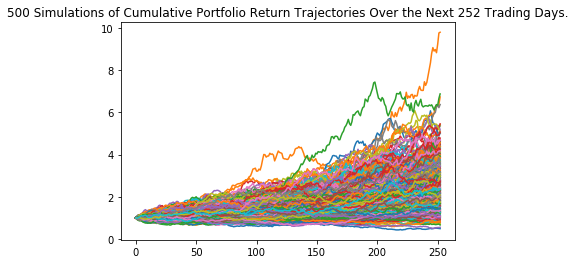

In [22]:
# Plot simulation outcomes
crypto_oneyr_line_plot = MC_crypto_one_year.plot_simulation()

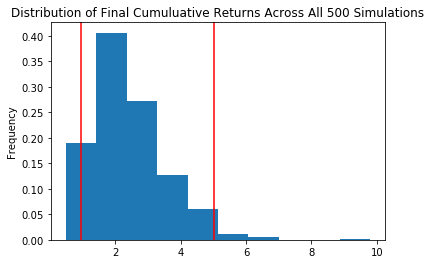

In [23]:
# Plot probability distribution and confidence intervals
crypto_oneyr_dist_plot = MC_crypto_one_year.plot_distribution()

In [24]:
# Fetch summary statistics from the Monte Carlo simulation results
crypto_oneyr_tbl = MC_crypto_one_year.summarize_cumulative_return()

# Print summary statistics
print(crypto_oneyr_tbl)

count           500.000000
mean              2.437465
std               1.106774
min               0.493996
25%               1.648089
50%               2.215185
75%               3.020858
max               9.795355
95% CI Lower      0.956273
95% CI Upper      5.018907
Name: 252, dtype: float64


In [25]:
# Configuring a Monte Carlo simulation to forecast 5 year cumulative returns
MC_crypto_five_year = MCSimulation(
    portfolio_data = crypto_close,
    weights = crypto_weight,
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [26]:
# Printing the simulation input data
MC_crypto_five_year.portfolio_data.head()

ADA-USD                                                      \
           Adj Close     Close      High       Low      Open      Volume   
2017-10-01  0.024969  0.024969  0.032226  0.017354  0.021678  50068700.0   
2017-10-02  0.025932  0.025932  0.030088  0.019969  0.024607  57641300.0   
2017-10-03  0.020816  0.020816  0.027425  0.020690  0.025757  16997800.0   
2017-10-04  0.021931  0.021931  0.022806  0.020864  0.020864   9000050.0   
2017-10-05  0.021489  0.021489  0.022154  0.020859  0.021951   5562510.0   

                             BTC-USD                            ...  LINK-USD  \
           daily_return    Adj Close        Close         High  ...      Open   
2017-10-01          NaN  4403.740234  4403.740234  4403.740234  ...  0.451547   
2017-10-02     0.038568  4409.319824  4409.319824  4470.229980  ...  0.437667   
2017-10-03    -0.197285  4317.479980  4317.479980  4432.470215  ...  0.367254   
2017-10-04     0.053565  4229.359863  4229.359863  4352.310059  ...  0.343186   
2017-10-05    -0.020154  4328.410156  4328.410156  4362.640137  ...  0.397030   

                                       LTC-USD                        \
                Volume daily_return  Adj Close      Close       High   
2017-10-01  10005100.0          NaN  54.543301  54.543301  55.161598   
2017-10-02   7101340.0    -0.182940  53.375999  53.375999  54.784801   
2017-10-03   8211990.0    -0.031483  52.349602  52.349602  53.592999   
2017-10-04   7604930.0     0.149988  51.399502  51.399502  53.046101   
2017-10-05   6291110.0     0.023095  51.669498  51.669498  51.865501   

                                                            
                  Low       Open       Volume daily_return  
2017-10-01  53.625198  55.136200  100183000.0          NaN  
2017-10-02  53.257999  54.546902   95474600.0    -0.021401  
2017-10-03  51.586601  53.390400   88516096.0    -0.019230  
2017-10-04  50.830399  52.284302   77473400.0    -0.018149  
2017-10-05  50.440498  51.401402   69594400.0     0.005253  

[5 rows x 35 columns]

In [27]:
# Running a Monte Carlo simulation to forecast 5 year cumulative returns
MC_crypto_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0           1          2          3           4          5    \
0      1.000000    1.000000   1.000000   1.000000    1.000000   1.000000   
1      1.010450    1.036578   0.997168   1.017594    1.029477   0.986335   
2      0.965327    1.062605   1.004031   1.034839    1.069343   1.002097   
3      1.038728    1.076421   1.074130   1.033912    1.066730   0.998541   
4      1.065099    1.080353   1.047910   1.042229    1.056083   1.022966   
...         ...         ...        ...        ...         ...        ...   
1256  73.659370  141.368151  81.192978  28.961439  152.395370  62.405911   
1257  74.343229  142.340409  78.411932  30.185146  147.286079  62.356578   
1258  74.459513  143.390294  79.456688  31.130831  154.384647  64.331993   
1259  75.789458  133.235921  79.141833  32.233914  158.741431  65.952299   
1260  72.980993  135.701799  80.221232  33.374565  164.280692  67.995723   

            6           7          8           9    ...        490        491  \
0      1.000000    1.000000   1.000000    1.000000  ...   1.000000   1.000000   
1      0.995726    1.046099   1.003713    1.041123  ...   1.046326   1.042522   
2      1.024330    1.074272   1.050253    1.016785  ...   1.017686   1.065178   
3      1.008460    1.066647   1.133678    1.015083  ...   1.015878   1.080414   
4      1.036267    1.062755   1.142588    1.008417  ...   1.076152   1.067218   
...         ...         ...        ...         ...  ...        ...        ...   
1256  70.407666  149.468752  49.367713  217.943730  ...  55.500102  36.189226   
1257  69.998882  153.772863  50.812204  215.929199  ...  58.570952  36.565371   
1258  69.927038  156.608655  50.573496  217.665407  ...  59.182793  37.666358   
1259  71.850530  153.014917  49.500188  223.240202  ...  55.399006  36.642323   
1260  76.983896  156.740257  48.323129  225.632346  ...  58.339002  38.220536   

            492        493        494         495         496         497  \
0      1.000000   1.000000   1.000000    1.000000    1.000000    1.000000   
1      0.963649   1.004688   0.998585    0.974100    1.017941    0.986414   
2      0.955179   0.990421   0.999178    1.021830    0.969888    1.013311   
3      0.974148   1.025909   0.956661    1.047525    0.940317    1.028299   
4      0.978949   1.012681   0.991551    1.085917    0.973131    1.007569   
...         ...        ...        ...         ...         ...         ...   
1256  81.144413  26.253033  36.458697  100.744424  104.107025  234.416734   
1257  79.467110  27.457387  36.263227  105.254362   99.210570  231.662103   
1258  76.748074  28.159530  37.271813  107.985377  102.008834  241.753969   
1259  78.104062  27.969294  36.314123  107.761609  103.440642  237.657900   
1260  79.211954  28.187053  37.810345  108.112282  104.428436  241.426105   

             498        499  
0       1.000000   1.000000  
1       1.010412   1.002056  
2       1.028870   0.998267  
3       1.034591   1.013986  
4       1.028458   0.985230  
...          ...        ...  
1256  109.479159  60.573079  
1257  115.127738  62.115771  
1258  118.165115  61.324160  
1259  123.027535  62.078192  
1260  116.341210  60.613175  

[1261 rows x 500 columns]

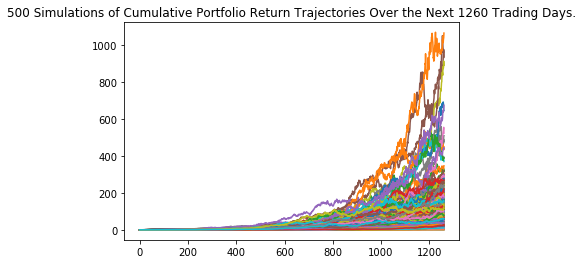

In [28]:
# Plot simulation outcomes
crypto_fiveyr_line_plot = MC_crypto_five_year.plot_simulation()

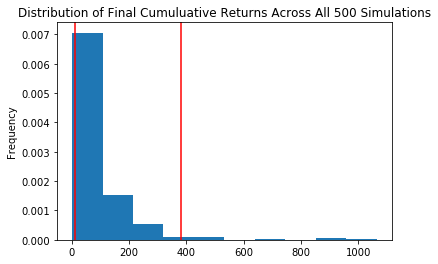

In [29]:
# Plot probability distribution and confidence intervals
crypto_fiveyr_dist_plot = MC_crypto_five_year.plot_distribution()

In [30]:
# Fetch summary statistics from the Monte Carlo simulation results
crypto_fiveyr_tbl = MC_crypto_five_year.summarize_cumulative_return()

# Print summary statistics
print(crypto_fiveyr_tbl)

count            500.000000
mean              89.574841
std              117.570514
min                1.186115
25%               29.882014
50%               55.397006
75%              107.338096
max             1063.755926
95% CI Lower       9.900101
95% CI Upper     380.504963
Name: 1260, dtype: float64


In [33]:
# S&P 500 Data
spbondStrings = ['AGG', 'SPY']

spagg_close = yf.download(spbondStrings, group_by='Ticker', period='10y')

# Create CSV of ticker data
spagg_close.to_csv('spagg.csv')

spagg_close = spagg_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

spagg_close = pd.read_csv('spagg.csv', header=[0, 1])
spagg_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
spagg_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(spagg_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
spagg_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
spagg_close.index.name = None

# Drop Null Information
spagg_close = spagg_close.dropna()

# Sort Multi-Index To Match Weights
spagg_close = spagg_close.reindex(sorted(spagg_close.columns), axis=1)

spagg_close

[*********************100%***********************]  2 of 2 completed


AGG                                                  \
             Adj Close       Close        High         Low        Open   
2011-06-27   83.548447  107.440002  107.699997  107.360001  107.699997   
2011-06-28   83.214050  107.010002  107.379997  106.949997  107.339996   
2011-06-29   82.965195  106.690002  107.089996  106.680000  107.029999   
2011-06-30   82.949669  106.669998  106.910004  106.400002  106.870003   
2011-07-01   82.976189  106.400002  106.540001  106.269997  106.500000   
...                ...         ...         ...         ...         ...   
2021-06-21  114.989998  114.989998  115.120003  114.919998  115.059998   
2021-06-22  115.110001  115.110001  115.139999  114.830002  114.830002   
2021-06-23  115.050003  115.050003  115.139999  114.989998  115.059998   
2021-06-24  115.089996  115.089996  115.169998  115.050003  115.099998   
2021-06-25  114.860001  114.860001  115.129997  114.750000  115.110001   

                              SPY                                      \
               Volume   Adj Close       Close        High         Low   
2011-06-27   730600.0  105.480721  127.940002  128.429993  126.639999   
2011-06-28  1038500.0  106.857574  129.610001  129.630005  128.270004   
2011-06-29  2533800.0  107.772713  130.720001  130.929993  129.630005   
2011-06-30  1295600.0  108.803261  131.970001  132.179993  130.710007   
2011-07-01  1970000.0  110.410950  133.919998  134.100006  131.779999   
...               ...         ...         ...         ...         ...   
2021-06-21  6875500.0  420.859985  420.859985  421.059998  415.929993   
2021-06-22  6485100.0  423.109985  423.109985  424.000000  420.079987   
2021-06-23  5070500.0  422.600006  422.600006  424.049988  422.510010   
2021-06-24  8357900.0  425.100006  425.100006  425.549988  424.619995   
2021-06-25  6496600.0  426.609985  426.609985  427.089996  425.549988   

                                     
                  Open       Volume  
2011-06-27  126.889999  168904700.0  
2011-06-28  128.449997  165556300.0  
2011-06-29  130.199997  244295500.0  
2011-06-30  131.139999  223322700.0  
2011-07-01  132.089996  202385700.0  
...                ...          ...  
2021-06-21  416.799988   72822000.0  
2021-06-22  420.850006   57700300.0  
2021-06-23  423.190002   49445400.0  
2021-06-24  424.890015   45110300.0  
2021-06-25  425.899994   58067900.0  

[2517 rows x 12 columns]

In [34]:
# Configuring a Monte Carlo simulation to forecast 1 year cumulative returns
MC_spagg_one_year = MCSimulation(
    portfolio_data = spagg_close,
    weights = [0.40, 0.60],
    num_simulation = 500,
    num_trading_days = 252 * 1
)

In [35]:
# Printing the simulation input data
MC_spagg_one_year.portfolio_data.head()

AGG                                                  \
            Adj Close       Close        High         Low        Open   
2011-06-27  83.548447  107.440002  107.699997  107.360001  107.699997   
2011-06-28  83.214050  107.010002  107.379997  106.949997  107.339996   
2011-06-29  82.965195  106.690002  107.089996  106.680000  107.029999   
2011-06-30  82.949669  106.669998  106.910004  106.400002  106.870003   
2011-07-01  82.976189  106.400002  106.540001  106.269997  106.500000   

                                           SPY                          \
               Volume daily_return   Adj Close       Close        High   
2011-06-27   730600.0          NaN  105.480721  127.940002  128.429993   
2011-06-28  1038500.0    -0.004002  106.857574  129.610001  129.630005   
2011-06-29  2533800.0    -0.002990  107.772713  130.720001  130.929993   
2011-06-30  1295600.0    -0.000187  108.803261  131.970001  132.179993   
2011-07-01  1970000.0    -0.002531  110.410950  133.919998  134.100006   

                                                              
                   Low        Open       Volume daily_return  
2011-06-27  126.639999  126.889999  168904700.0          NaN  
2011-06-28  128.270004  128.449997  165556300.0     0.013053  
2011-06-29  129.630005  130.199997  244295500.0     0.008564  
2011-06-30  130.710007  131.139999  223322700.0     0.009562  
2011-07-01  131.779999  132.089996  202385700.0     0.014776

In [36]:
# Running a Monte Carlo simulation to forecast 1 year cumulative returns
MC_spagg_one_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1    1.002317  1.008356  0.994255  1.011718  1.011192  0.996345  0.995095   
2    1.004801  1.005456  0.990379  1.013698  1.006370  0.995249  0.988630   
3    1.008767  0.996567  0.987455  1.011311  1.017638  0.986713  0.987684   
4    0.998911  0.997817  1.000827  1.027551  1.022657  0.990125  0.992912   
..        ...       ...       ...       ...       ...       ...       ...   
248  1.008412  1.138567  1.023343  1.029723  1.079549  1.048992  0.958057   
249  1.006465  1.127771  1.024897  1.023384  1.079239  1.056103  0.963644   
250  0.993447  1.134154  1.020586  1.024061  1.089125  1.050542  0.980307   
251  0.997065  1.134156  1.021273  1.023949  1.090470  1.063403  0.979231   
252  0.989395  1.128843  1.016164  1.021611  1.076634  1.049159  0.979194   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.012523  1.004418  0.998322  ...  0.994834  0.990591  0.999822   
2    1.014460  1.012752  1.015551  ...  0.992529  0.987278  0.998064   
3    1.017910  1.019854  1.023886  ...  0.990202  0.990583  0.992988   
4    1.026520  1.016564  1.010344  ...  0.979600  0.994480  0.995261   
..        ...       ...       ...  ...       ...       ...       ...   
248  1.232445  1.263090  0.908208  ...  1.147724  1.000418  1.086281   
249  1.232459  1.263137  0.907360  ...  1.135652  1.002425  1.083249   
250  1.235383  1.245516  0.921561  ...  1.144398  0.999669  1.082516   
251  1.223468  1.256546  0.928483  ...  1.141874  0.986820  1.079828   
252  1.226195  1.268092  0.942937  ...  1.152863  0.991745  1.093007   

          493       494       495       496       497       498       499  
0    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1    0.993502  1.000343  1.008326  1.006045  1.002838  1.010556  0.999559  
2    0.997620  1.004707  1.014951  1.004790  1.001630  1.014006  1.000059  
3    0.995408  0.993253  1.010100  1.004755  0.991110  1.017171  1.008150  
4    0.997267  0.996005  1.016057  1.007942  0.997459  1.021621  0.993288  
..        ...       ...       ...       ...       ...       ...       ...  
248  1.073287  0.890324  1.220904  0.923431  1.099028  1.181612  1.132925  
249  1.084634  0.885049  1.242144  0.927992  1.100393  1.191922  1.135116  
250  1.083896  0.887018  1.249199  0.923816  1.098346  1.192496  1.136940  
251  1.087571  0.885030  1.245490  0.918725  1.096702  1.181490  1.134128  
252  1.074979  0.890027  1.241342  0.911418  1.098895  1.178477  1.135913  

[253 rows x 500 columns]

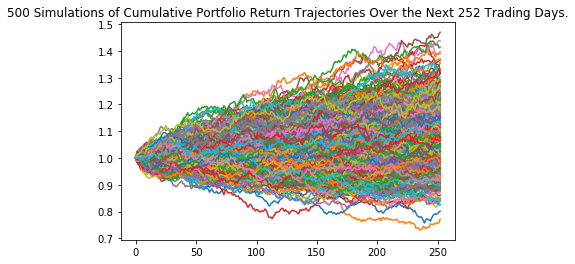

In [37]:
# Plot simulation outcomes
spagg_oneyr_line_plot = MC_spagg_one_year.plot_simulation()

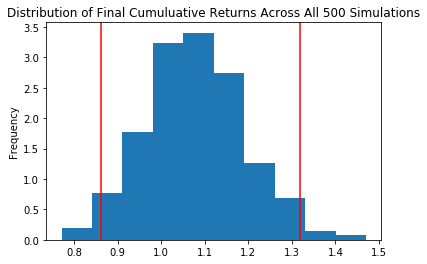

In [38]:
# Plot probability distribution and confidence intervals
spagg_oneyr_dist_plot = MC_spagg_one_year.plot_distribution()

In [39]:
# Fetch summary statistics from the Monte Carlo simulation results
spagg_oneyr_tbl = MC_spagg_one_year.summarize_cumulative_return()

# Print summary statistics
print(spagg_oneyr_tbl)

count           500.000000
mean              1.079188
std               0.114238
min               0.771267
25%               0.998855
50%               1.075377
75%               1.157893
max               1.469927
95% CI Lower      0.862235
95% CI Upper      1.317697
Name: 252, dtype: float64


In [40]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_spagg_five_year = MCSimulation(
    portfolio_data = spagg_close,
    weights = [0.40, 0.60],
    num_simulation = 500,
    num_trading_days = 252 * 5
)

In [45]:
# Printing the simulation input data
MC_spagg_five_year.portfolio_data.head()

AGG                                                  \
            Adj Close       Close        High         Low        Open   
2011-06-27  83.548447  107.440002  107.699997  107.360001  107.699997   
2011-06-28  83.214050  107.010002  107.379997  106.949997  107.339996   
2011-06-29  82.965195  106.690002  107.089996  106.680000  107.029999   
2011-06-30  82.949669  106.669998  106.910004  106.400002  106.870003   
2011-07-01  82.976189  106.400002  106.540001  106.269997  106.500000   

                                           SPY                          \
               Volume daily_return   Adj Close       Close        High   
2011-06-27   730600.0          NaN  105.480721  127.940002  128.429993   
2011-06-28  1038500.0    -0.004002  106.857574  129.610001  129.630005   
2011-06-29  2533800.0    -0.002990  107.772713  130.720001  130.929993   
2011-06-30  1295600.0    -0.000187  108.803261  131.970001  132.179993   
2011-07-01  1970000.0    -0.002531  110.410950  133.919998  134.100006   

                                                              
                   Low        Open       Volume daily_return  
2011-06-27  126.639999  126.889999  168904700.0          NaN  
2011-06-28  128.270004  128.449997  165556300.0     0.013053  
2011-06-29  129.630005  130.199997  244295500.0     0.008564  
2011-06-30  130.710007  131.139999  223322700.0     0.009562  
2011-07-01  131.779999  132.089996  202385700.0     0.014776

In [46]:
# Running a Monte Carlo simulation to forecast 5 year cumulative returns
MC_spagg_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.000755  0.990045  0.994976  1.005272  1.011914  0.993378  1.013757   
2     1.003232  0.993037  1.008760  1.013423  1.011612  1.004023  1.009282   
3     1.008299  0.998999  1.008792  1.009511  1.004197  1.013977  1.011473   
4     1.007591  1.010089  1.018735  1.001943  1.010182  1.016221  1.013015   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.801345  1.192886  1.343344  2.100996  2.285668  1.663584  1.544779   
1257  1.813921  1.201773  1.360373  2.122634  2.290135  1.658222  1.523235   
1258  1.821352  1.202076  1.358934  2.151152  2.279610  1.648756  1.529845   
1259  1.824293  1.201104  1.360632  2.168778  2.274951  1.628076  1.517044   
1260  1.799463  1.204500  1.364332  2.172638  2.261659  1.623716  1.500269   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.003432  1.006656  1.002419  ...  1.001622  1.001205  0.994538   
2     0.998762  1.012941  0.989706  ...  1.003431  0.995018  0.998178   
3     0.991244  1.018234  0.993312  ...  0.997885  0.989865  1.000947   
4     0.992521  1.024644  0.983838  ...  1.008893  0.979505  0.994759   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.814380  1.975353  1.974449  ...  1.079732  2.662273  1.915227   
1257  1.823908  1.949498  1.959618  ...  1.078304  2.663427  1.925619   
1258  1.842677  1.946379  1.971301  ...  1.076741  2.701073  1.941390   
1259  1.846682  1.939043  1.966085  ...  1.080528  2.715233  1.926342   
1260  1.853741  1.931757  1.958652  ...  1.084832  2.715549  1.922867   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.001710  1.001792  1.006015  0.988541  1.003628  1.013659  1.004316  
2     1.002273  1.002977  1.004558  0.991566  1.016876  1.022983  0.998537  
3     1.009587  1.000689  0.994148  0.984201  1.025666  1.031959  0.996216  
4     1.015490  1.004964  0.994470  0.980886  1.022682  1.034034  0.985432  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.940374  1.034487  1.100133  2.100350  1.632817  2.226024  1.085356  
1257  1.944712  1.023018  1.110177  2.101354  1.633562  2.219652  1.088900  
1258  1.941633  1.025089  1.108287  2.120817  1.633306  2.212349  1.088987  
1259  1.933864  1.018151  1.111671  2.116830  1.633101  2.203083  1.093003  
1260  1.941359  1.023770  1.119033  2.111175  1.628508  2.180364  1.092016  

[1261 rows x 500 columns]

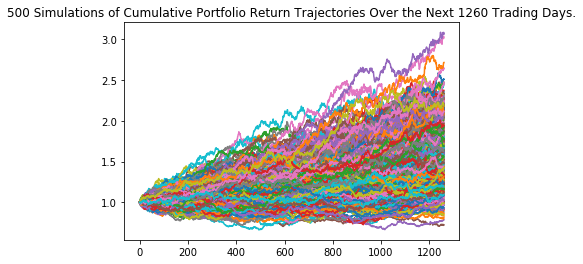

In [47]:
# Plot simulation outcomes
spagg_fiveyr_line_plot = MC_spagg_five_year.plot_simulation()

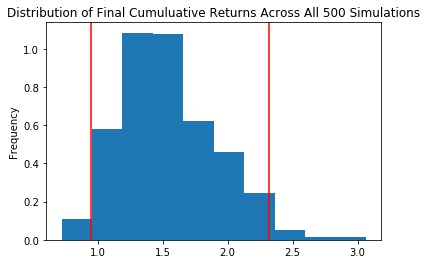

In [48]:
# Plot probability distribution and confidence intervals
spagg_fiveyr_dist_plot = MC_spagg_five_year.plot_distribution()

In [49]:
# Fetch summary statistics from the Monte Carlo simulation results
spagg_fiveyr_tbl = MC_spagg_five_year.summarize_cumulative_return()

# Print summary statistics
print(spagg_fiveyr_tbl)

count           500.000000
mean              1.544860
std               0.375627
min               0.721751
25%               1.274972
50%               1.497667
75%               1.785200
max               3.063817
95% CI Lower      0.944309
95% CI Upper      2.318716
Name: 1260, dtype: float64


In [58]:
# QQQ Data
qqqStrings = ['QQQ']

qqq_close = yf.download(qqqStrings, group_by='Ticker', period='10y')

# Create CSV of ticker data
qqq_close.to_csv('qqq.csv')

qqq_close = qqq_close.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

qqq_close = pd.read_csv('qqq.csv', header=[0, 1])
qqq_close.drop([0], axis=0, inplace=True)  # drop this row because it only has one column with Date in it
#qqq_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')] = pd.to_datetime(qqq_close[('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], format='%Y-%m-%d')  # convert the first column to a datetime
#qqq_close.set_index(('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), inplace=True)  # set the first column as the index
qqq_close.index.name = None

# Drop Null Information
qqq_close = qqq_close.dropna()

# Sort Multi-Index To Match Weights
qqq_close = qqq_close.reindex(sorted(qqq_close.columns), axis=1)

qqq_close

[*********************100%***********************]  1 of 1 completed


Adj Close       Close        Date               High  \
     49.999427795410156       55.25  2011-06-27 55.529998779296875   
1             50.949657   56.299999  2011-06-29          56.410000   
2             51.628384   57.049999  2011-06-30          57.090000   
3             52.406651   57.910000  2011-07-01          57.990002   
4             52.669102   58.200001  2011-07-05          58.259998   
5             52.841038   58.389999  2011-07-06          58.490002   
...                 ...         ...         ...                ...   
2511         344.359985  344.359985  2021-06-21         344.690002   
2512         347.570007  347.570007  2021-06-22         348.029999   
2513         347.739990  347.739990  2021-06-23         348.920013   
2514         349.890015  349.890015  2021-06-24         351.459991   
2515         349.459991  349.459991  2021-06-25         350.720001   

                   Low               Open    Volume  
     54.31999969482422 54.439998626708984  49968900  
1            55.900002          56.200001  65407300  
2            56.470001          56.500000  50347200  
3            56.919998          57.080002  53203900  
4            57.830002          57.970001  43128800  
5            57.939999          58.130001  49282700  
...                ...                ...       ...  
2511        340.149994         342.429993  32992600  
2512        343.839996         344.149994  28941600  
2513        346.880005         347.510010  27188500  
2514        349.170013         349.730011  32581600  
2515        348.839996         350.470001  28627400  

[2515 rows x 7 columns]

In [59]:
# Configuring a Monte Carlo simulation to forecast 1 year cumulative returns
MC_qqq_one_year = MCSimulation(
    portfolio_data = qqq_close,
    num_simulation = 500,
    num_trading_days = 252 * 1
)

KeyError: 'Close'